In [130]:
import os
import pickle
import random
from os.path import join
from tifffile import imread
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

from scipy.ndimage import gaussian_filter1d

In [131]:
# from ultrack.imgproc import normalize
# from ultrack.utils.array import array_apply

In [132]:
cwd = os.getcwd()

In [133]:
cwd

'/Users/jg/projects/DSLab/DSL'

In [134]:
# file = Path("../Data files/input/4T1 p27 trial period.HTD - Well D02 Field #3.tif")
file = Path("input/4T1 p27 trial period.HTD - Well B05 Field #1.tif")
config_id = 100
processing = '_ppc'
plot_dpi = 500

In [135]:
experiment = Path(file).stem
parent_dir = Path(file).parent.parent
data_dir = Path(join(parent_dir, "output", experiment))
input_file = Path(join(parent_dir, "input", file.name))

In [136]:
print(experiment, "\n", data_dir,"\n",  input_file)

4T1 p27 trial period.HTD - Well B05 Field #1 
 output/4T1 p27 trial period.HTD - Well B05 Field #1 
 input/4T1 p27 trial period.HTD - Well B05 Field #1.tif


In [137]:
normalized_path = data_dir / "normalized.npy"
cellpose_path = data_dir / "cellpose_labels.npy"
wscp_path = data_dir / "wscp_labels.npy"
stardist_path = data_dir / "stardist_labels.npy"
wssd_path = data_dir / "wssd_labels.npy"
detection_path = data_dir / f"{config_id}" / "detections.npz"
tracks_path = data_dir / f"{config_id}" / f"tracks{processing}.pkl"
track_label_path = data_dir / f"{config_id}" / f"track_labels{processing}.npy"
graph_path = data_dir / f"{config_id}" / f"graph{processing}.pkl"
plots_path = data_dir / f"{config_id}" / f"plots{processing}"
os.makedirs(plots_path, exist_ok=True)

In [138]:
with open(graph_path, "rb") as f:
    graph = pickle.load(f)

In [139]:
image = imread(input_file)

In [140]:
image = image[:, 1:, :, :]
image = np.swapaxes(image, 1, 3)

In [141]:
image.shape

(234, 1024, 1024, 4)

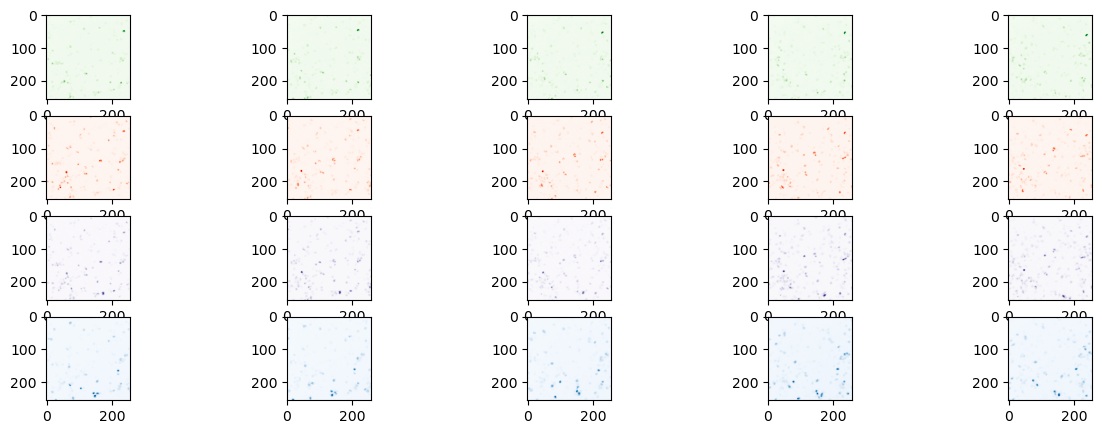

In [142]:
fig, ax = plt.subplots(4, 5, figsize=(15, 5))
for time in range(5):
    ax[0, time].imshow(image[time, :256, :256, 0], cmap="Greens")
    ax[1, time].imshow(image[time, :256, :256, 1], cmap="Reds")
    ax[2, time].imshow(image[time, :256, :256, 2], cmap="Purples")
    ax[3, time].imshow(image[time, :256, :256, 3], cmap="Blues")
plt.savefig(plots_path / f"raw_images.png", dpi=plot_dpi)

In [143]:
tracks_df = pd.read_pickle(tracks_path)

In [144]:
track_labels = np.load(track_label_path)

In [145]:
BLUE_FLAG = (image.shape[1] > 4)

In [146]:
tracks_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2
id,,,,,,,,,,
3000002,1,2,3.0,295.0,3000002,-1,-1,0.517573,0.182058,0.300369
4000006,1,3,4.0,294.0,4000006,-1,3000002,0.456241,0.239598,0.304161
5000010,1,4,6.0,298.0,5000010,-1,4000006,0.412807,0.264599,0.322594
6000025,1,5,11.0,293.0,6000025,-1,5000010,0.407295,0.256750,0.335956
7000018,7626,6,9.0,293.0,7000018,-1,-1,0.142763,0.366678,0.490560
8000050,7627,7,18.0,293.0,8000050,-1,-1,0.490679,0.201802,0.307519
9000048,7628,8,17.0,293.0,9000048,-1,-1,0.135081,0.373503,0.491416
10000057,7629,9,21.0,284.0,10000057,-1,-1,0.338295,0.190122,0.471583
11000062,7629,10,29.0,289.0,11000062,-1,10000057,0.438454,0.197716,0.363830


In [147]:
def invert_graph(graph):
    inverse_graph = {}
    for key, value in graph.items():
        if value in inverse_graph.keys():
            inverse_graph[value].append(key)
        else:
            inverse_graph[value] = [key]
    return inverse_graph

In [148]:
graph

{3: 2,
 4: 3,
 5: 3,
 6: 2,
 19: 18,
 21: 7662,
 22: 7662,
 23: 7666,
 24: 7666,
 26: 18,
 32: 7688,
 35: 7688,
 38: 37,
 39: 37,
 42: 39,
 43: 39,
 46: 7713,
 47: 46,
 48: 46,
 49: 48,
 50: 48,
 51: 7713,
 61: 7764,
 66: 7764,
 74: 7798,
 75: 74,
 80: 74,
 81: 7798,
 84: 7808,
 85: 7808,
 89: 7819,
 90: 89,
 91: 90,
 92: 90,
 93: 89,
 94: 7819,
 96: 7816,
 97: 7828,
 98: 7828,
 99: 7816,
 101: 7836,
 102: 101,
 103: 101,
 106: 7836,
 115: 114,
 120: 7882,
 121: 7882,
 124: 114,
 134: 133,
 135: 133,
 137: 7901,
 138: 7901,
 141: 7916,
 146: 7925,
 147: 7925,
 148: 7916,
 150: 149,
 151: 149,
 153: 152,
 163: 7951,
 164: 7951,
 166: 152,
 167: 166,
 168: 7955,
 169: 168,
 170: 168,
 171: 7955,
 172: 166,
 184: 7985,
 185: 7985,
 187: 7992,
 190: 7992,
 191: 190,
 192: 190,
 194: 193,
 197: 193,
 200: 199,
 203: 8028,
 204: 8028,
 210: 8054,
 217: 8054,
 223: 199,
 230: 8130,
 231: 8130,
 234: 8137,
 235: 8137,
 243: 8170,
 244: 8170,
 245: 8178,
 246: 8178,
 247: 246,
 248: 246,
 250: 

In [149]:
def get_lines(tracks_df, graph):
    all_tracks = tracks_df["track_id"].unique()

    igraph = invert_graph(graph)

    all_tracks = all_tracks[
        np.isin(all_tracks, np.array(list(graph.keys())), invert=True)
    ]

    def recurse_tracks(all_tracks, parent=None):
        for track_id in all_tracks:
            track = tracks_df[tracks_df["track_id"] == track_id]
            if parent is not None:
                track = pd.concat([parent, track])

            if track_id in igraph.keys():
                yield from recurse_tracks(igraph[track_id], track)
            else:
                yield track

    yield from recurse_tracks(all_tracks)

In [150]:
def get_single_line(track_id, tracks_df, graph):
    for track in get_lines(tracks_df, graph):
        if track_id in track["track_id"].values:
            return track

In [151]:
len(tracks_df)

203896

In [152]:
def populate_cell_intensities(image, track_labels, tracks_df):
    """Get the mean of the intensity of each channel for each track.

    Args:
            image (np.ndarray): numpy array of the image of the shape
                    (time, channels, h, w)
            track_labels (np.ndarray): an numpy array of labels generated
                    by ultrack
            tracks_df (pd.DataFrame): tracks dataframe from ultracks analysis

    Returns:
            pd.DataFrame: tracks dataframe merged with average intensities for
                    each cell
    """
    columns = ["green_intensity", "red_intensity", "farred_intensity"]
    if BLUE_FLAG:
        columns.append("blue_intensity")
    intensities = pd.DataFrame(columns=columns, index=tracks_df.index)

    def compute_intensities(row):
        time = int(row["t"])

        track_mask = track_labels[time] == row["track_id"]
        inten_dict = {
            "green_intensity": np.mean(image[time, :, :, 0][track_mask]),
            "red_intensity": np.mean(image[time, :, :, 1][track_mask]),
            "farred_intensity": np.mean(image[time, :, :, 2][track_mask]),
        }
        if BLUE_FLAG:
            inten_dict["blue_intensity"] = np.mean(image[time, :, :, 3][track_mask])

        return pd.Series(inten_dict)

    intensities = tracks_df.progress_apply(compute_intensities, axis=1)

    tracks_df = pd.merge(tracks_df, intensities, left_index=True, right_index=True)

    return tracks_df

In [153]:
track_intensity_df = populate_cell_intensities(image, track_labels, tracks_df)

  0%|          | 0/203896 [00:00<?, ?it/s]

/Users/jg/miniforge3/envs/display/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jg/miniforge3/envs/display/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [154]:
track_intensity_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,,,,
3000002,1,2,3.0,295.0,3000002,-1,-1,0.517573,0.182058,0.300369,1047.049180,552.262295,654.688525,287.557377
4000006,1,3,4.0,294.0,4000006,-1,3000002,0.456241,0.239598,0.304161,1036.270270,506.081081,625.527027,288.175676
5000010,1,4,6.0,298.0,5000010,-1,4000006,0.412807,0.264599,0.322594,949.345679,491.185185,622.777778,276.456790
6000025,1,5,11.0,293.0,6000025,-1,5000010,0.407295,0.256750,0.335956,971.419753,540.740741,629.641975,282.839506
7000018,7626,6,9.0,293.0,7000018,-1,-1,0.142763,0.366678,0.490560,808.613333,823.333333,810.000000,302.320000
8000050,7627,7,18.0,293.0,8000050,-1,-1,0.490679,0.201802,0.307519,NaN,NaN,NaN,NaN
9000048,7628,8,17.0,293.0,9000048,-1,-1,0.135081,0.373503,0.491416,NaN,NaN,NaN,NaN
10000057,7629,9,21.0,284.0,10000057,-1,-1,0.338295,0.190122,0.471583,NaN,NaN,NaN,NaN
11000062,7629,10,29.0,289.0,11000062,-1,10000057,0.438454,0.197716,0.363830,NaN,NaN,NaN,NaN


In [155]:
i = 3
for track in get_lines(track_intensity_df, graph):
    # i -= 1
    # if i == 0:
    # 	single_track = track
    # 	break
    if len(track["track_id"].unique()) > 3:
        i -= 1
        if i == 0:
            single_track = track
            break

In [156]:
single_track

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,,,,
17000240,7819,16,68.0,408.0,17000240,-1,-1,0.192422,0.423329,0.384248,NaN,NaN,NaN,NaN
18000263,7819,17,68.0,410.0,18000263,-1,17000240,0.099094,0.445960,0.454947,NaN,NaN,NaN,NaN
19000253,7819,18,75.0,414.0,19000253,-1,18000263,0.234925,0.389963,0.375112,NaN,NaN,NaN,NaN
20000277,7819,19,80.0,422.0,20000277,-1,19000253,0.432092,0.291117,0.276791,NaN,NaN,NaN,NaN
21000277,7819,20,86.0,417.0,21000277,-1,20000277,0.296429,0.359722,0.343849,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96000631,91,95,122.0,389.0,96000631,90,95000581,0.359235,0.312487,0.328278,1513.967742,1573.602151,1382.333333,1036.806452
97000666,91,96,123.0,387.0,97000666,90,96000631,0.352762,0.302639,0.344598,1647.738095,1746.666667,1560.059524,1126.178571
98000607,91,97,125.0,382.0,98000607,90,97000666,0.364931,0.295458,0.339611,1887.054795,1981.479452,1747.082192,1243.890411


In [157]:
def get_intensity_graph(single_intensity_track, smooth = None):
    """Generates a line graph of the intensity of each channel. Also
    indicates when the track was split.
    Note: Locally normalized.

    # TODO: Format graph. Normalize y value (might need to change the function call to do this).

    Args:
            single_intensity_track (pd.DataFrame): a subset of the
                    track_intensity_df which contains a single track line.
                    Must contain intensity columns.
    """
    time = single_intensity_track["t"]
    green_intensity = single_intensity_track["green_intensity"]
    green_intensity = (green_intensity - green_intensity.min()) / (
        green_intensity.max() - green_intensity.min()
    )
    red_intensity = single_intensity_track["red_intensity"]
    red_intensity = (red_intensity - red_intensity.min()) / (
        red_intensity.max() - red_intensity.min()
    )
    farred_intensity = single_intensity_track["farred_intensity"]
    farred_intensity = (farred_intensity - farred_intensity.min()) / (
        farred_intensity.max() - farred_intensity.min()
    )
    if BLUE_FLAG:
        blue_intensity = single_intensity_track["blue_intensity"]
        blue_intensity = (blue_intensity - blue_intensity.min()) / (
            blue_intensity.max() - blue_intensity.min()
        )

    separation_points = []
    lines = single_intensity_track["track_id"].unique()

    for line_idx in lines:
        line = single_intensity_track[single_intensity_track["track_id"] == line_idx]
        if line.iloc[0]["parent_id"] == -1:
            continue
        else:
            separation_points.append(min(line.t))

    fig = plt.figure(figsize=(15, 5))

    if smooth is not None:
        green_intensity_smoothed = gaussian_filter1d(green_intensity, sigma=smooth)
        red_intensity_smoothed = gaussian_filter1d(red_intensity, sigma=smooth)
        farred_intensity_smoothed = gaussian_filter1d(farred_intensity, sigma=smooth)
        if BLUE_FLAG:
            blue_intensity_smoothed = gaussian_filter1d(blue_intensity, sigma=smooth)
        
        plt.plot(time, green_intensity_smoothed, color="green")
        plt.plot(time, red_intensity_smoothed, color="red")
        plt.plot(time, farred_intensity_smoothed, color="purple")
        if BLUE_FLAG:
            plt.plot(time, blue_intensity_smoothed, color="blue")
    
    plt.plot(time, green_intensity, alpha=0.2 if smooth else 1, label="Green", color="green")
    plt.plot(time, red_intensity, alpha=0.2 if smooth else 1, label="Red", color="red")
    plt.plot(time, farred_intensity, alpha=0.2 if smooth else 1, label="Far Red", color="purple")
    if BLUE_FLAG:
        plt.plot(time, blue_intensity, alpha=0.2 if smooth else 1, label="Blue", color="blue")
        
    plt.legend(['Green', 'Red', 'Far Red', 'Blue'])
    top, bottom = plt.ylim()
    plt.vlines(
        separation_points,
        ymin=top,
        ymax=bottom,
        color="black",
    )
    # plt.show()
    plt.savefig(plots_path / f"single_intensity_graph.png", dpi=plot_dpi)

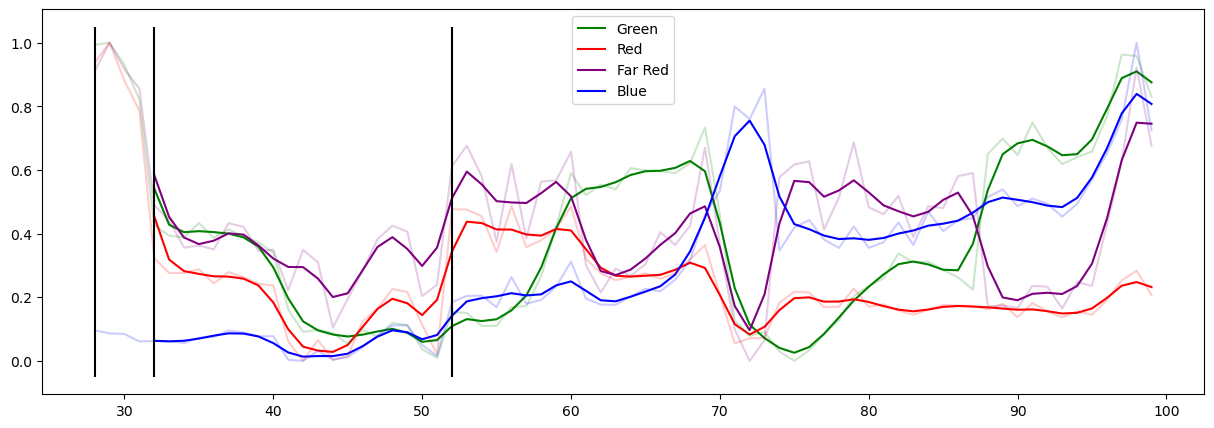

In [158]:
get_intensity_graph(single_track, smooth=1)

In [159]:
def get_tracking_images(image, track_labels, single_track, padding=10):
    """Gets a list of images of each cell in the track
    for each channel.

    **or**

    Generates a list of images of each cell in the track
    for each channel.

    Args:
            image (np.ndarray): numpy array of the image of the
                    shape (time, channels, h, w)
            single_track (pd.DataFrame): a subset of tracks_df
                    containing a single track line.
    """
    channels = image.shape[3] + 1
    total_time = len(single_track)
    fig, ax = plt.subplots(channels, total_time, figsize=(15, 5))

    for cell in single_track.itertuples():
        time = cell.t

        track_mask_idx = np.where(track_labels[time] == cell.track_id)
        track_mask = (track_labels[time] == cell.track_id)
        xbounds = (track_mask_idx[0].min() - padding, track_mask_idx[0].max() + padding)
        xbounds = (int(max(0, xbounds[0])), int(min(image.shape[1], xbounds[1])))
        ybounds = (track_mask_idx[1].min() - padding, track_mask_idx[1].max() + padding)
        ybounds = (int(max(0, ybounds[0])), int(min(image.shape[2], ybounds[1])))

        ax[0][time].imshow(
            track_mask[xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]], cmap="gray"
        )
        ax[0][time].get_xaxis().set_visible(False)
        ax[0][time].get_yaxis().set_visible(False)
        ax[1][time].imshow(
            image[time, :, :, 0][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Greens",
        )
        ax[1][time].get_yaxis().set_visible(False)
        ax[1][time].get_xaxis().set_visible(False)
        ax[2][time].imshow(
            image[time, :, :, 1][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Reds",
        )
        ax[2][time].get_xaxis().set_visible(False)
        ax[2][time].get_yaxis().set_visible(False)
        ax[3][time].imshow(
            image[time, :, :, 2][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Purples",
        )
        ax[3][time].get_xaxis().set_visible(False)
        ax[3][time].get_yaxis().set_visible(False)
        if BLUE_FLAG:
            ax[4][time].imshow(
                image[time, :, :, 3][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
                cmap="Blues",
            )
            ax[4][time].get_xaxis().set_visible(False)
            ax[4][time].get_yaxis().set_visible(False)

    # plt.show()
    plt.savefig(plots_path / f"tracking_images.png", dpi=plot_dpi)

ValueError: zero-size array to reduction operation minimum which has no identity

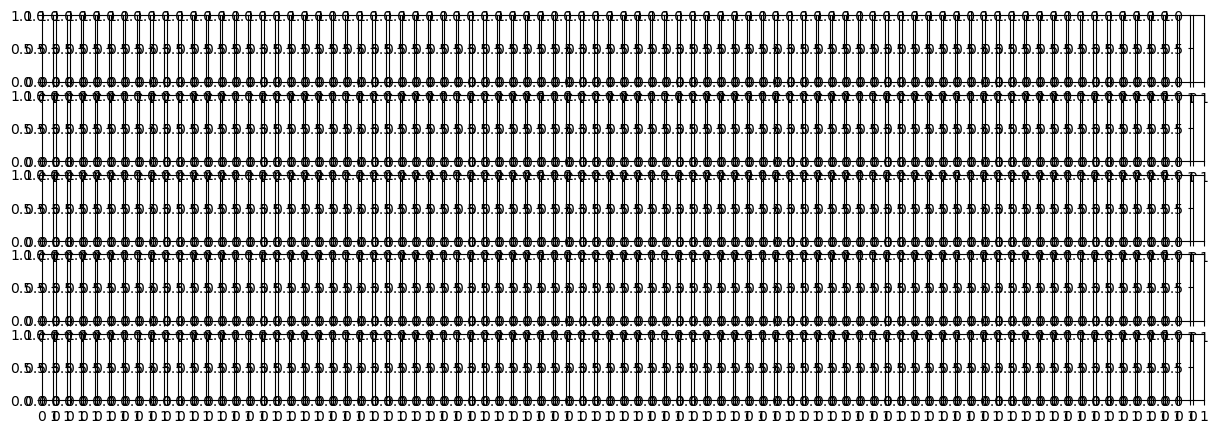

In [160]:
get_tracking_images(image, track_labels, single_track, padding=10)

In [161]:
def get_track_lengths(tracks_df, graph):
	for track in get_lines(tracks_df, graph):
		yield len(track)

In [162]:
def get_average_intensity_graph(tracks_df, graph):
    # tracks_df.loc[:, "green_intensity"] = (
    #     tracks_df["green_intensity"] - tracks_df["green_intensity"].min()
    # ) / (tracks_df["green_intensity"].max() - tracks_df["green_intensity"].min())
    # tracks_df.loc[:, "red_intensity"] = (
    #     tracks_df["red_intensity"] - tracks_df["red_intensity"].min()
    # ) / (tracks_df["red_intensity"].max() - tracks_df["red_intensity"].min())
    # tracks_df.loc[:, "farred_intensity"] = (
    #     tracks_df["farred_intensity"] - tracks_df["farred_intensity"].min()
    # ) / (tracks_df["farred_intensity"].max() - tracks_df["farred_intensity"].min())
    # if BLUE_FLAG:
    #     tracks_df.loc[:, "blue_intensity"] = (
    #         tracks_df["blue_intensity"] - tracks_df["blue_intensity"].min()
    #     ) / (tracks_df["blue_intensity"].max() - tracks_df["blue_intensity"].min())

    time_groups = tracks_df.groupby(by="t")

    tracks_df_means = time_groups.mean(numeric_only=True)
    tracks_df_std = time_groups.std(numeric_only=True)
    tracks_df_len = time_groups.count()

    Z_SCORE = 1.96

    plt.plot(
        tracks_df_means.index,
        tracks_df_means["green_intensity"],
        label="Gree",
        color="green",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["green_intensity"]
        - Z_SCORE
        * tracks_df_std["green_intensity"]
        / tracks_df_len["green_intensity"].pow(0.5),
        tracks_df_means["green_intensity"]
        + Z_SCORE
        * tracks_df_std["green_intensity"]
        / tracks_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        tracks_df_means.index,
        tracks_df_means["red_intensity"],
        label="Red",
        color="red",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["red_intensity"]
        - Z_SCORE
        * tracks_df_std["red_intensity"]
        / tracks_df_len["red_intensity"].pow(0.5),
        tracks_df_means["red_intensity"]
        + Z_SCORE
        * tracks_df_std["red_intensity"]
        / tracks_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        tracks_df_means.index,
        tracks_df_means["farred_intensity"],
        label="Far Red",
        color="purple",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["farred_intensity"]
        - Z_SCORE
        * tracks_df_std["farred_intensity"]
        / tracks_df_len["farred_intensity"].pow(0.5),
        tracks_df_means["farred_intensity"]
        + Z_SCORE
        * tracks_df_std["farred_intensity"]
        / tracks_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            tracks_df_means.index,
            tracks_df_means["blue_intensity"],
            label="Blue",
            color="blue",
        )
        plt.fill_between(
            tracks_df_means.index,
            tracks_df_means["blue_intensity"]
            - Z_SCORE
            * tracks_df_std["blue_intensity"]
            / tracks_df_len["blue_intensity"].pow(0.5),
            tracks_df_means["blue_intensity"]
            + Z_SCORE
            * tracks_df_std["blue_intensity"]
            / tracks_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )
    plt.legend()
    # plt.show()
    plt.savefig(plots_path / f"average_intensity_graph.png", dpi=plot_dpi)

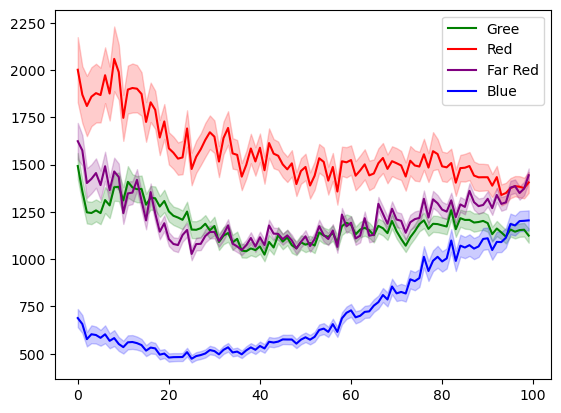

In [163]:
get_average_intensity_graph(track_intensity_df, graph)

In [164]:
def iterSample(iterable, samplesize):
    results = []

    for i, v in enumerate(iterable):
        r = random.randint(0, i)
        if r < samplesize:
            if i < samplesize:
                results.insert(r, v) # add first samplesize items in random order
            else:
                results[r] = v # at a decreasing rate, replace random items

    if len(results) < samplesize:
        raise ValueError("Sample larger than population.")

    return results

In [165]:
offset_df = pd.DataFrame(columns = tracks_df.columns)
random_tracks = iterSample(get_lines(tracks_df, graph), 3)
last_split_time = 0

for single_track in random_tracks:
	lines = single_track["track_id"].unique()

	for line_idx in lines:
		line = single_track[single_track["track_id"] == line_idx]
		if min(line.t) > last_split_time:
			last_split_time = min(line["t"])

	if last_split_time > 0:
		single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
		offset_df = pd.concat([offset_df, single_track])
	

/var/folders/fy/xrqtxc7d7xj4p71p4xs089s40000gn/T/ipykernel_37635/2133525651.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  offset_df = pd.concat([offset_df, single_track])


In [166]:
offset_df

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2
74003985,18524,0,860.0,146.0,74003985,-1,-1,0.665794,0.206571,0.127635
75004036,18524,1,859.0,150.0,75004036,-1,74003985,0.657759,0.200919,0.141322
76004085,18524,2,857.0,153.0,76004085,-1,75004036,0.614880,0.216267,0.168852
77004180,18524,3,859.0,155.0,77004180,-1,76004085,0.616234,0.226118,0.157648
78004128,18524,4,861.0,153.0,78004128,-1,77004180,0.620192,0.218299,0.161508
79004168,18524,5,859.0,154.0,79004168,-1,78004128,0.588116,0.246549,0.165335
80004095,18524,6,856.0,152.0,80004095,-1,79004168,0.589140,0.261237,0.149623
60002035,21737,-14,453.0,486.0,60002035,-1,-1,0.299077,0.375405,0.325518
61002084,21737,-13,455.0,486.0,61002084,-1,60002035,0.263792,0.396673,0.339536
96004724,13880,0,919.0,221.0,96004724,-1,-1,0.000000,0.325390,0.674610


In [167]:
def get_offset_intensity_graphs(tracks_df, graph):
    random_tracks = iterSample(get_lines(tracks_df, graph), 3)
    last_split_time = 0
    
    fig, ax = plt.subplots(1, 4 if BLUE_FLAG else 3, figsize=(15, 5))

    for single_track in random_tracks:
        lines = single_track["track_id"].unique()

        for line_idx in lines:
            line = single_track[single_track["track_id"] == line_idx]
            if min(line.t) > last_split_time:
                last_split_time = min(line["t"])

        if last_split_time > 0:
            single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
        
        label = "\n+ ".join([str(x) for x in single_track["track_id"].unique()])

        ax[0].plot(single_track["t"], single_track["green_intensity"], label = label)
        ax[1].plot(single_track["t"], single_track["red_intensity"], label = label)
        ax[2].plot(single_track["t"], single_track["farred_intensity"], label = label)
        if BLUE_FLAG:
            ax[3].plot(single_track["t"], single_track["blue_intensity"], label = label)
        
        ax[0].set_title("Green Channel")
        ax[1].set_title("Red Channel")
        ax[2].set_title("Far Red Channel")
        if BLUE_FLAG:
            ax[3].set_title("Blue Channel")
    
    top, bottom = plt.ylim()
    for axis in ax:
        axis.vlines(
            0,
            ymin=top,
            ymax=bottom,
            color="black",
        )
        axis.set_xlim(left=-25)

    handles, labels = ax[-1].get_legend_handles_labels()
    print(handles, labels)
    fig.legend(handles, labels, loc='outside upper right')
    # plt.show()
    plt.savefig(plots_path / f"offset_intensity_graphs.png", dpi=plot_dpi)

[<matplotlib.lines.Line2D object at 0x168634df0>, <matplotlib.lines.Line2D object at 0x168635f00>, <matplotlib.lines.Line2D object at 0x168637010>] ['17856', '9928', '10590']


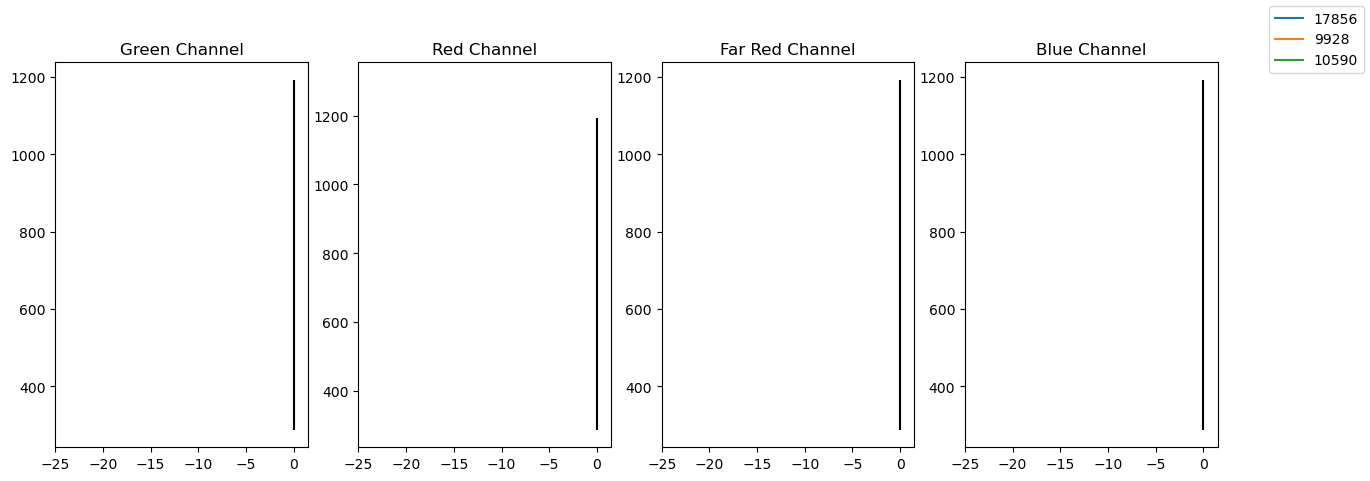

In [168]:
get_offset_intensity_graphs(track_intensity_df, graph)

In [169]:
def get_average_offset_intensity_graph(tracks_df, graph):
    """Get the average intensity over all tracks with time
            offset to the last split for each track.
        Intensities are normalized over their track.

        Skip the tracks which do not split.

    Args:
            tracks_df (pd.DataFrame): DataFrame of all tracks
            graph (dict): dictionary generated from ultrack
                    with track hiearchy.
    """
    offset_df = pd.DataFrame(columns=tracks_df.columns)
    for single_track in get_lines(tracks_df, graph):
        last_split_time = 0
        lines = single_track["track_id"].unique()

        single_track.loc[:, "green_intensity"] = (single_track["green_intensity"] - single_track["green_intensity"].min()) / (single_track["green_intensity"].max() - single_track["green_intensity"].min())
        single_track.loc[:, "red_intensity"] = (single_track["red_intensity"] - single_track["red_intensity"].min()) / (single_track["red_intensity"].max() - single_track["red_intensity"].min())
        single_track.loc[:, "farred_intensity"] = (single_track["farred_intensity"] - single_track["farred_intensity"].min()) / (single_track["farred_intensity"].max() - single_track["farred_intensity"].min())
        if BLUE_FLAG:
            single_track.loc[:, "blue_intensity"] = (single_track["blue_intensity"] - single_track["blue_intensity"].min()) / (single_track["blue_intensity"].max() - single_track["blue_intensity"].min())

        for line_idx in lines:
            line = single_track[single_track["track_id"] == line_idx]
            if min(line.t) > last_split_time:
                last_split_time = min(line["t"])

        if last_split_time > 0:
            single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
            offset_df = pd.concat([offset_df, single_track])

    time_groups = offset_df.groupby(by="t")

    offset_df_means = time_groups.mean(numeric_only=True)
    offset_df_std = time_groups.std(numeric_only=True)
    offset_df_len = time_groups.count()

    Z_SCORE = 1.96

    plt.plot(
        offset_df_means.index,
        offset_df_means["green_intensity"],
        label="Green",
        color="green",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["green_intensity"]
        - Z_SCORE
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        offset_df_means["green_intensity"]
        + Z_SCORE
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["red_intensity"],
        label="Red",
        color="red",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["red_intensity"]
        - Z_SCORE
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        offset_df_means["red_intensity"]
        + Z_SCORE
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["farred_intensity"],
        label="Far Red",
        color="purple",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["farred_intensity"]
        - Z_SCORE
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        offset_df_means["farred_intensity"]
        + Z_SCORE
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            offset_df_means.index,
            offset_df_means["blue_intensity"],
            label="Blue",
            color="blue",
        )
        plt.fill_between(
            offset_df_means.index,
            offset_df_means["blue_intensity"]
            - Z_SCORE
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            offset_df_means["blue_intensity"]
            + Z_SCORE
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )
        
    top, bottom = plt.ylim()
    plt.vlines(
        0,
        ymin=top,
        ymax=bottom,
        color="black",
    )
    plt.legend()
    plt.xlim(left=-25)
    # plt.show()
    plt.savefig(plots_path / f"average_offset_intensity_graph.png", dpi=plot_dpi)

/var/folders/fy/xrqtxc7d7xj4p71p4xs089s40000gn/T/ipykernel_37635/3170609066.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  offset_df = pd.concat([offset_df, single_track])


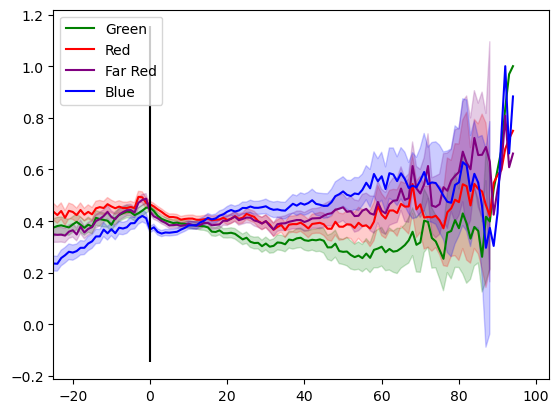

In [170]:
get_average_offset_intensity_graph(track_intensity_df, graph)

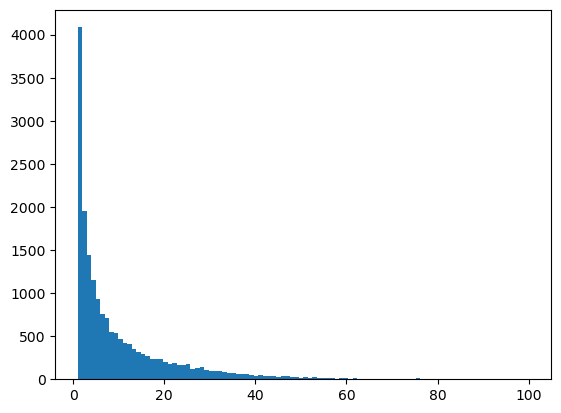

In [171]:
last_line_lengths = []
for single_track in get_lines(tracks_df, graph):
	last_split_time = 0
	last_line_idx = single_track.iloc[0]["track_id"]
	lines = single_track.track_id.unique()

	for line_idx in lines:
		line = single_track[single_track["track_id"] == line_idx]
		if min(line.t) > last_split_time:
			last_split_time = min(line.t)
			last_line_idx = line_idx
	
	last_line = single_track[single_track["track_id"] == last_line_idx]
	if len(last_line) == 0:
		print(single_track)
	last_line_lengths.append(len(last_line))
plt.hist(last_line_lengths, bins=100)
# plt.show()
plt.savefig(plots_path / f"last_line_lengths.png", dpi=plot_dpi)

In [172]:
min(last_line_lengths)

1